In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install soundfile

In [3]:
import soundfile
import numpy as np
import librosa
import glob
import os
from sklearn.model_selection import train_test_split

# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

In [4]:
def preprocess_audio(file_path, target_sr=16000):
    """
    Load, resample, and normalize audio.
    Args:
    - file_path: Path to the audio file
    - target_sr: Target sampling rate
    Returns:
    - audio_signal: Processed audio signal
    - sr: Sampling rate
    """
    # Load audio file
    audio_signal, sr = librosa.load(file_path, sr=target_sr)

    # Trim silence
    audio_signal, _ = librosa.effects.trim(audio_signal)

    # Normalize the audio signal
    audio_signal = librosa.util.normalize(audio_signal)

    return audio_signal, sr

In [5]:
def extract_feature(file_name, **kwargs):
    """
    Extract features from an audio file.
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        Example:
            `features = extract_feature(path, mel=True, mfcc=True)`
    """
    # Feature flags
    mfcc = kwargs.get("mfcc", False)
    chroma = kwargs.get("chroma", False)
    mel = kwargs.get("mel", False)
    contrast = kwargs.get("contrast", False)
    tonnetz = kwargs.get("tonnetz", False)

    try:
        # Load audio file
        with soundfile.SoundFile(file_name) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate = sound_file.samplerate

        # Initialize result array
        result = np.array([])

        # Short-time Fourier transform for chroma and contrast
        stft = np.abs(librosa.stft(X)) if chroma or contrast else None

        # Extract features
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma and stft is not None:
            chroma_features = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma_features))
        if mel:
            mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel_spectrogram))
        if contrast and stft is not None:
            contrast_features = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast_features))
        if tonnetz:
            tonnetz_features = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz_features))

        return result

    except Exception as e:
        print(f"Error extracting features from {file_name}: {e}")
        return None


In [6]:
def load_data(test_size=0.2):
    X, y = [], []
    files = glob.glob("/content/drive/My Drive/wav/Actor_*/*.wav")
    print(f"Found {len(files)} audio files.")

    if not files:
        raise ValueError("No audio files found in the specified directory.")

    for file in files:
        try:
            basename = os.path.basename(file)
            emotion_key = basename.split("-")[2]
            emotion = int2emotion.get(emotion_key, None)

            if emotion is None or emotion not in AVAILABLE_EMOTIONS:
                continue

            features = extract_feature(file, mfcc=True, chroma=True, mel=True, contrast=True)

            if features is None or not isinstance(features, np.ndarray):
                continue

            X.append(features)
            y.append(emotion)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if len(X) == 0:
        raise ValueError("No valid samples collected. Check the emotion labels and feature extraction.")

    return train_test_split(np.array(X), y, test_size=test_size, random_state=42)

In [7]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25)
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
# this is a vector of features extracted
# using utils.extract_features() method
print("[+] Number of features:", X_train.shape[1])

Found 1440 audio files.


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2
  warnings.warn(


Error extracting features from /content/drive/My Drive/wav/Actor_20/03-01-03-01-02-01-20.wav: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)
[+] Number of training samples: 503
[+] Number of testing samples: 168
[+] Number of features: 187


**DECISION TREE**

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Accuracy: 0.64

Classification Report:
               precision    recall  f1-score   support

       angry       0.73      0.75      0.74        55
       happy       0.57      0.49      0.53        47
     neutral       0.68      0.57      0.62        23
         sad       0.58      0.72      0.65        43

    accuracy                           0.64       168
   macro avg       0.64      0.63      0.63       168
weighted avg       0.64      0.64      0.64       168


Confusion Matrix:
 [[41 10  0  4]
 [13 23  1 10]
 [ 1  1 13  8]
 [ 1  6  5 31]]


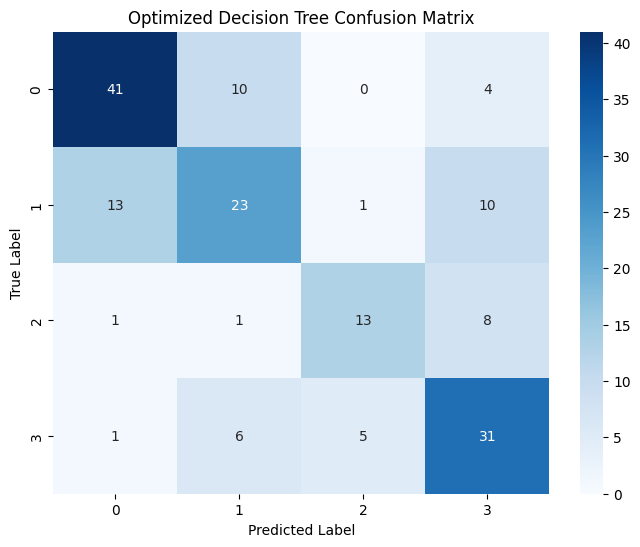

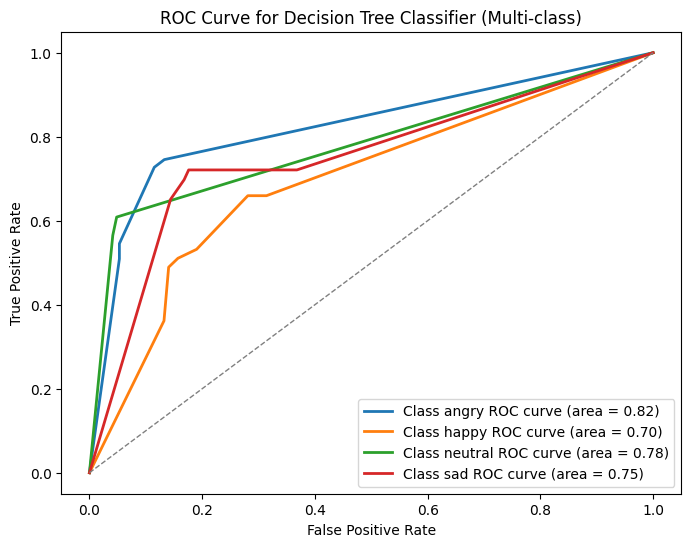

Class distribution in y_train: {'sad': 149, 'angry': 137, 'happy': 144, 'neutral': 73}
Class distribution in y_test: {'sad': 43, 'happy': 47, 'angry': 55, 'neutral': 23}


In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=0)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid,
    scoring='accuracy',  # Metric for evaluation
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Display progress
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_dtree = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_dtree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, title="Optimized Decision Tree Confusion Matrix")

# ROC Curve and AUC calculation
n_classes = len(set(y_test))

if n_classes == 2:
    # Binary classification
    y_probs = best_dtree.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Decision Tree Classifier')
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification: One-vs-Rest (OvR) strategy
    try:
        # Binarize test labels
        classes = sorted(list(set(y_train)))  # Ensure consistent classes from training
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_dtree.predict_proba(X_test)  # Probabilities for all classes

        # Plot ROC Curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Decision Tree Classifier (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")

# Debugging: Check dataset distribution
print("Class distribution in y_train:", dict(Counter(y_train)))
print("Class distribution in y_test:", dict(Counter(y_test)))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.7797619047619048

Classification Report:
               precision    recall  f1-score   support

       angry       0.91      0.78      0.84        55
       happy       0.71      0.87      0.78        47
     neutral       0.74      0.61      0.67        23
         sad       0.75      0.77      0.76        43

    accuracy                           0.78       168
   macro avg       0.78      0.76      0.76       168
weighted avg       0.79      0.78      0.78       168



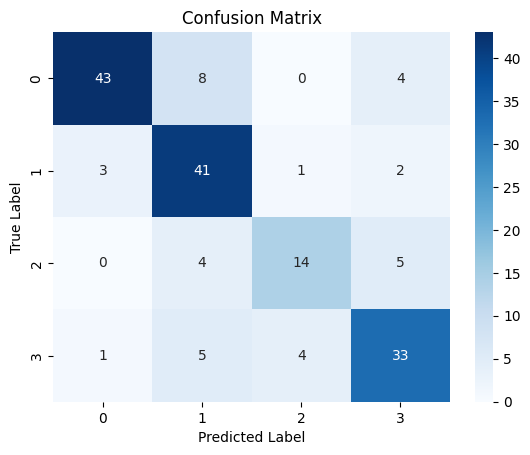

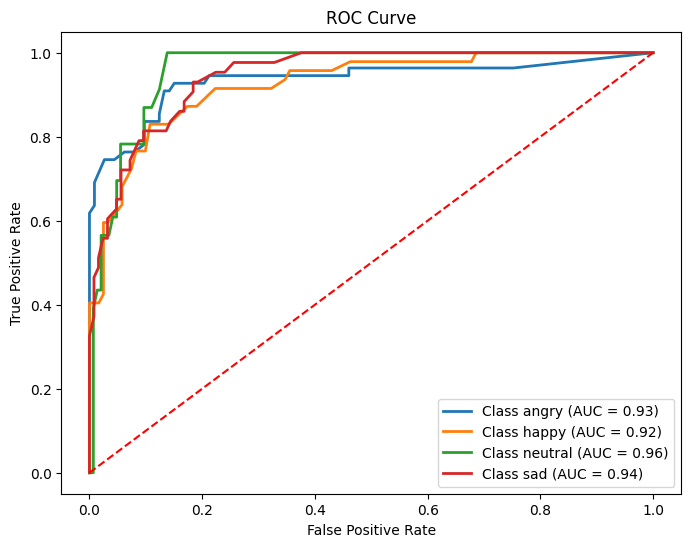

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Random Forest parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# GridSearchCV for Random Forest
rf_classifier = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_probs = best_rf.predict_proba(X_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred)

# ROC-AUC Curve
n_classes = len(np.unique(y_test))
classes = np.unique(y_test)

plt.figure(figsize=(8, 6))
if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc(fpr, tpr):.2f})", color='blue')
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=classes)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
        plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


**SUPPORT VECTOR MACHINE**

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.79

Classification Report:
               precision    recall  f1-score   support

       angry       0.88      0.82      0.85        55
       happy       0.77      0.77      0.77        47
     neutral       0.77      0.74      0.76        23
         sad       0.71      0.79      0.75        43

    accuracy                           0.79       168
   macro avg       0.78      0.78      0.78       168
weighted avg       0.79      0.79      0.79       168


Confusion Matrix:
 [[45  7  1  2]
 [ 4 36  1  6]
 [ 0  0 17  6]
 [ 2  4  3 34]]


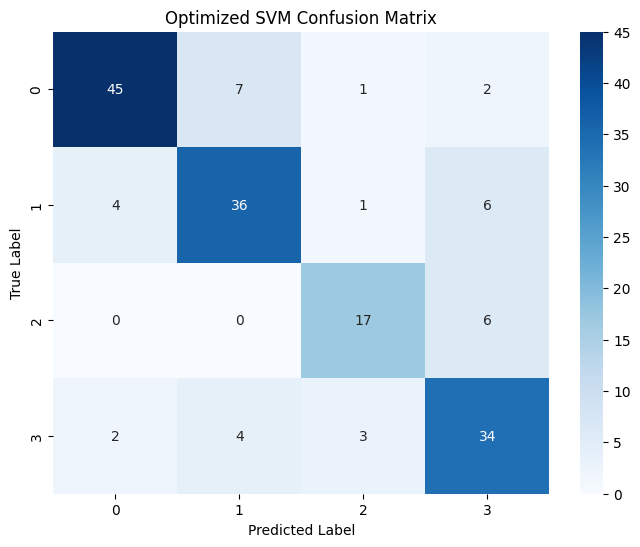

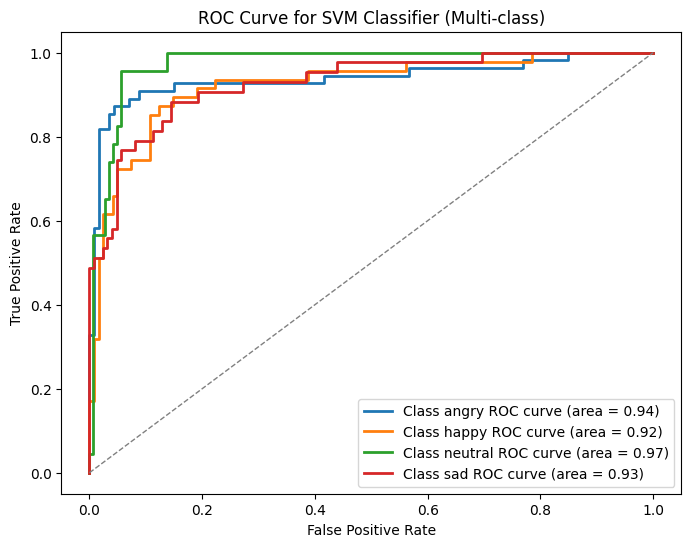

Class distribution in y_train: {'sad': 149, 'angry': 137, 'happy': 144, 'neutral': 73}
Class distribution in y_test: {'sad': 43, 'happy': 47, 'angry': 55, 'neutral': 23}


In [9]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only relevant for 'poly' kernel
}

# Initialize the SVM classifier
svm = SVC(probability=True, random_state=0)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Display progress
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model to the training data
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_svm = grid_search.best_estimator_

# Evaluate the best model on the test set
svm_predictions = best_svm.predict(X_test_scaled)
print(f"Accuracy: {accuracy_score(y_test, svm_predictions):.2f}")
print("\nClassification Report:\n", classification_report(y_test, svm_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_predictions))

# Visualize Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, svm_predictions, title="Optimized SVM Confusion Matrix")

# ROC Curve and AUC calculation
n_classes = len(set(y_test))

if n_classes == 2:
    # Binary classification
    y_probs = best_svm.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for SVM Classifier')
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification: One-vs-Rest (OvR) strategy
    try:
        # Binarize test labels
        classes = sorted(list(set(y_train)))  # Ensure consistent classes from training
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_svm.predict_proba(X_test_scaled)  # Probabilities for all classes

        # Plot ROC Curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for SVM Classifier (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")

# Debugging: Check dataset distribution
print("Class distribution in y_train:", dict(Counter(y_train)))
print("Class distribution in y_test:", dict(Counter(y_test)))


**RANDOM FOREST**

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'var_smoothing': 1.0}
[Naive Bayes] Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

       angry       0.79      0.55      0.65        55
       happy       0.42      0.47      0.44        47
     neutral       0.00      0.00      0.00        23
         sad       0.41      0.74      0.53        43

    accuracy                           0.50       168
   macro avg       0.41      0.44      0.40       168
weighted avg       0.48      0.50      0.47       168


Confusion Matrix:
 [[30 20  0  5]
 [ 7 22  0 18]
 [ 0  0  0 23]
 [ 1 10  0 32]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


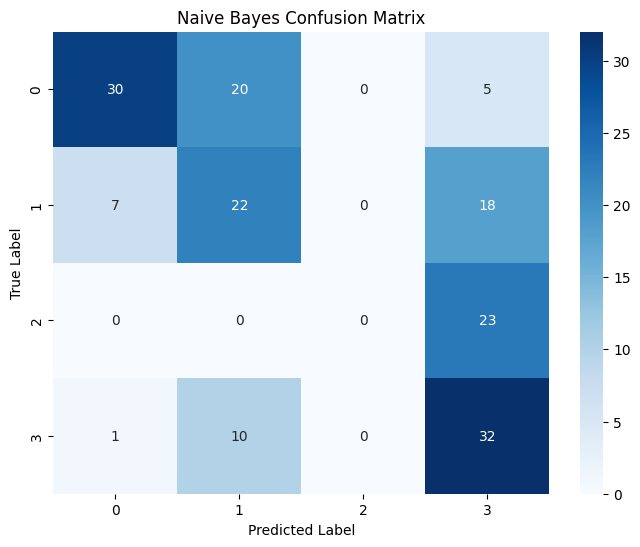

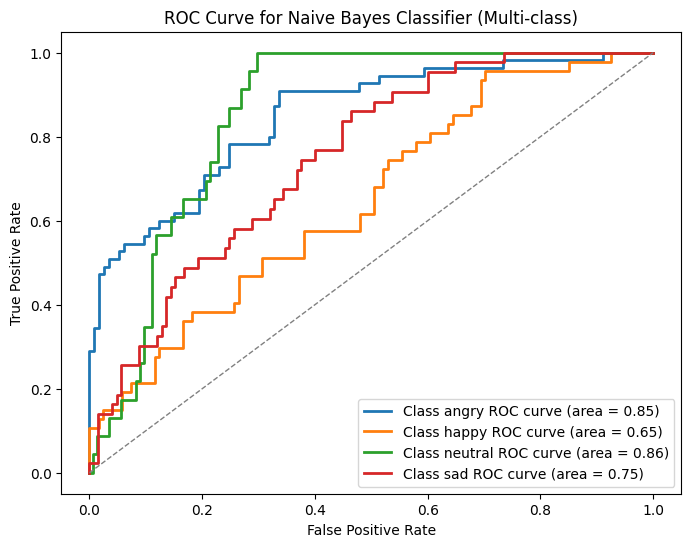

In [12]:

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Parameter grid for GridSearchCV
param_grid = {
    'var_smoothing': np.logspace(-9, 0, 10)  # Common range for Naive Bayes variance smoothing
}

# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=nb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model
print(f"Best Parameters: {grid_search.best_params_}")
best_nb_classifier = grid_search.best_estimator_

# Make predictions
y_pred = best_nb_classifier.predict(X_test)

# Evaluate the classifier
print("[Naive Bayes] Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, title="Naive Bayes Confusion Matrix")

# ROC Curve and AUC calculation
n_classes = len(set(y_test))

if n_classes == 2:
    # Binary classification
    y_probs = best_nb_classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Naive Bayes Classifier')
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification: One-vs-Rest (OvR) strategy
    try:
        # Binarize test labels
        classes = sorted(list(set(y_train)))  # Ensure consistent classes from training
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_nb_classifier.predict_proba(X_test)  # Probabilities for all classes

        # Plot ROC Curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Naive Bayes Classifier (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.61625743 0.66407921 0.56455446 0.62619802 0.53871287 0.60237624
 0.54085149 0.58445545 0.54073267 0.59837624        nan 0.67392079
        nan 0.6479802         nan 0.62021782        nan 0.58049505
        nan 0.58641584 0.61625743 0.66407921 0.56455446 0.62619802
 0.53871287 0.60237624 0.54085149 0.58445545 0.54073267 0.59837624]
  warnings.warn(


Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
[Optimized KNN] Accuracy: 0.7380952380952381

Classification Report:
               precision    recall  f1-score   support

       angry       0.85      0.64      0.73        55
       happy       0.65      0.77      0.71        47
     neutral       0.77      0.87      0.82        23
         sad       0.72      0.77      0.74        43

    accuracy                           0.74       168
   macro avg       0.75      0.76      0.75       168
weighted avg       0.75      0.74      0.74       168


Confusion Matrix:
 [[35 15  0  5]
 [ 3 36  3  5]
 [ 0  0 20  3]
 [ 3  4  3 33]]


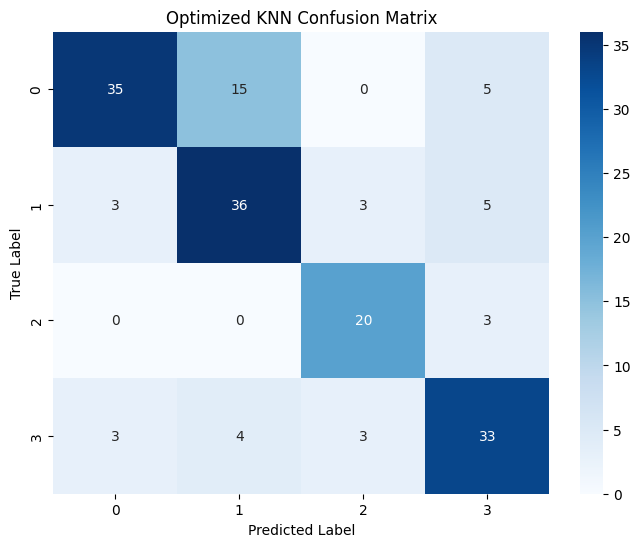

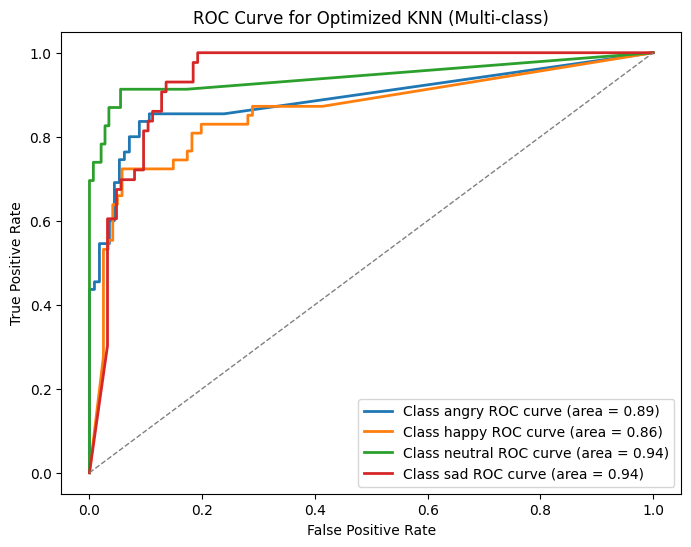

Class distribution in y_train: {'sad': 149, 'angry': 137, 'happy': 144, 'neutral': 73}
Class distribution in y_test: {'sad': 43, 'happy': 47, 'angry': 55, 'neutral': 23}


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Try different k values
    'weights': ['uniform', 'distance'],  # Uniform or distance-based weights
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Initialize the KNN classifier
knn_classifier = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Use all processors
)

# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model
best_knn = grid_search.best_estimator_

# Make predictions using the best model
knn_predictions = best_knn.predict(X_test_scaled)

# Evaluate the model
print("[Optimized KNN] Accuracy:", accuracy_score(y_test, knn_predictions))
print("\nClassification Report:\n", classification_report(y_test, knn_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, knn_predictions))

# Confusion Matrix Visualization
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

plot_confusion_matrix(y_test, knn_predictions, title="Optimized KNN Confusion Matrix")

# --- ROC and AUC Curve ---
# Check number of classes
n_classes = len(np.unique(y_test))

if n_classes == 2:
    # Binary classification
    y_probs = best_knn.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Optimized KNN (Binary Classification)')
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification: One-vs-Rest (OvR) strategy
    try:
        # Binarize test labels
        classes = sorted(np.unique(y_train))  # Ensure consistent classes from training
        y_test_binarized = label_binarize(y_test, classes=classes)
        y_probs = best_knn.predict_proba(X_test_scaled)  # Probabilities for all classes

        # Plot ROC Curve for each class
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Optimized KNN (Multi-class)')
        plt.legend(loc="lower right")
        plt.show()

    except ValueError as e:
        print(f"Error during ROC calculation: {e}")
        print("Ensure that y_test contains all necessary classes.")

# Debugging: Check class distribution
from collections import Counter
print("Class distribution in y_train:", dict(Counter(y_train)))
print("Class distribution in y_test:", dict(Counter(y_test)))


<ipython-input-22-4c87f4daec0c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


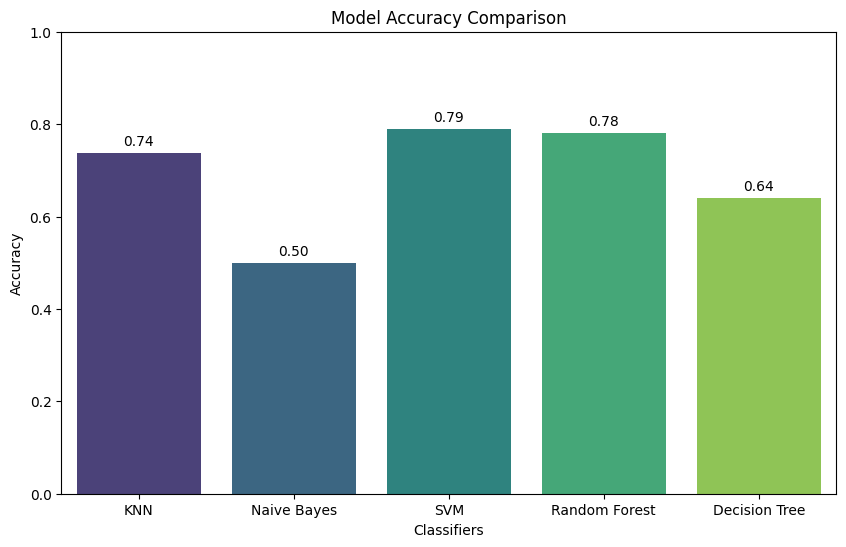

In [22]:
def plot_accuracy_comparison(models, accuracies, title="Classifier Accuracy Comparison"):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=models, y=accuracies, palette="viridis")
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Classifiers")
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center", va="bottom", fontsize=10)
    plt.show()

# Example usage:
models = ['KNN', 'Naive Bayes', 'SVM', 'Random Forest', 'Decision Tree']
accuracies = [0.7381, 0.5, 0.79, 0.7798, 0.64]

plot_accuracy_comparison(models, accuracies, title="Model Accuracy Comparison")
